# STA 220 Assignment 3

# Jake Tierney, Student ID: 913235409

Due __Februrary 23, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__(a, i)__ Write a function that retrieves all links to movies in the database by scraping the _alphabetical_ section on [imsdb.com](https://imsdb.com/) and retrieve the links. _How many links did you find?_ __(ii)__ Write a function `fetch_script` that, given the link of a movie retrieved in (i), returns a dictionary that contains all relevant information of the movie: 

```python
fetch_script('/Movie Scripts/10 Things I Hate About You Script.html')

>>> {'title': '10 Things I Hate About You',
     'writers': ['Karen McCullah Lutz', 'Kirsten Smith', 'William Shakespeare'],
     'genres': ['Comedy', 'Romance'],
     'date': 1997,
     'script': '...'}
```

The `script` field contains a string of the scraped script. Retrieve the information for all movies. _How many scripts did you retrieve?_

In [1]:
# Importing requisite modules
import requests as rq
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

In [2]:
# Problem a, part (i)

# Defining a function that takes the IMSDB all scripts url as input and outputs a list of script URLs
def fetchlinks(input_url):

    # Requesting the url data
    response = rq.get(input_url)
    
    # Parsing the html data and finding all links on the page
    data = BeautifulSoup(response.content, 'html.parser')
    links = data.find_all('a')
    
    # Converting the links data into a list of strings
    page = []
    for i in links:
        page.append(str(i))


    # Subsetting the list of strings to only the links for movie scripts
    first_script = page.index('<a href="https://imsdb.com/all-scripts.html">ALL SCRIPTS</a>') + 1
    last_script = page.index('<a href="https://imsdb.com" title="Internet Movie Script Database (IMSDb)">Index</a>')
    scripts = page[first_script:last_script]

    # Initializing the final list of script urls
    final_links = []

    # Appending the final url for each script to the final_links list
    for i in range(0, len(scripts)):
        script_url = "https://imsdb.com" + scripts[i][scripts[i].find('href=') + 6:scripts[i].find('title=') - 2]
        final_links.append(script_url)

    # Returning the final list of script urls
    return final_links

# Initializing the imsdb url and running the fetchlinks function on it
imsdb = "https://imsdb.com/all-scripts.html"
scriptlinks = fetchlinks(imsdb)

# Printing the length of the scriptlinks list
len(scriptlinks)

1221

SOLUTION: There are 1221 links to movies on the imsdb website.

In [3]:
# Problem a, part (ii)

# Defining a function that takes the movie url as input and outputs a dictionary of the relevant info
def fetch_script(movie_url):

    # Getting the movie information from the movie's url
    response = rq.get(movie_url)
    data = BeautifulSoup(response.text, 'html.parser')
    script_details = data.find('table', class_='script-details')

    if script_details:

        # Converting the script_details data into a list of strings
        details = []
        for i in script_details:
            details.append(str(i))
    
        # Defining the movie title
        movietitle = details[3][details[3].find('title=') + 7:details[3].find('Script') - 1]
    
        # Defining the movie writers
        moviewriters = []
        for i in details[3].split('writer.php?w=')[1:]:
            name = i[:i.find('title=') - 2]
            moviewriters.append(name)
    
        # Defining the movie genres
        moviegenres = []
        for i in details[3].split('/genre/')[1:]:
            genre = i[:i.find('title=') - 2]
            moviegenres.append(genre)
    
        # Defining the movie date
        if len(details[3].split('Date</b>')) == 1:
            moviedate = ''
        else:
            moviedate = details[3].split('Date</b>')[1][details[3].split('Date</b>')[1].find('<br/>') - 4:details[3].split('Date</b>')[1].find('<br/>')]
        
        # Slicing for the script url
        scriptslice1 = details[3].split('br/>\n<br/>\n')[1].find('href=') + 6
        scriptslice2 = details[3].split('br/>\n<br/>\n')[1].find('>Read') - 1
        script_url = "https://imsdb.com" + details[3].split('br/>\n<br/>\n')[1][scriptslice1:scriptslice2]
    
        # If statement setting the script text to None if there is no script url
        if script_url == 'https://imsdb.com\n</t':
            clean_text = 'None'
    
        else:
            # Getting the script text from the url
            script = rq.get(script_url)
            scripthtml = BeautifulSoup(script.text, 'html.parser')
            script_text = scripthtml.find('td', class_='scrtext')
    
            # Cleaning the script text to remove html and \r \n characters
            clean_text = re.sub('<.*?>', '', str(script_text))
            clean_text = clean_text.replace('\r', '').replace('\n', '')

    else:
        movietitle = ''
        moviewriters = ''
        moviegenres = ''
        moviedate = ''
        clean_text = ''
        
    # Creating the dictionary for this movie
    movie_info = {
        'title': movietitle,
        'writers': moviewriters,
        'genres': moviegenres,
        'date': moviedate,
        'script': clean_text
    }

    return movie_info

# Initiating the list that we will append script information dictionaries to
script_list = []

# Running the fetch_script function for each of the movie urls found in part (i)
for i in scriptlinks:
    info = fetch_script(i)
    script_list.append(info)

# Counting the number of scripts that have been retrieved
has_script = []
for i in range(0, len(script_list)):
    if script_list[i]['script'] != 'None':
        has_script.append(i)

len(has_script)

1160

SOLUTION: We retrieved 1160 scripts from the 1221 movie URLs returned from part (i).

__(b)__ We are interested in the genres `'Musical'`, `'Horror'`, and `'Romance'`. Craft a barplot displaying the absolute counts for each of these categories. In each bar, color-code the fractions of movies that are also counted in another genres. 

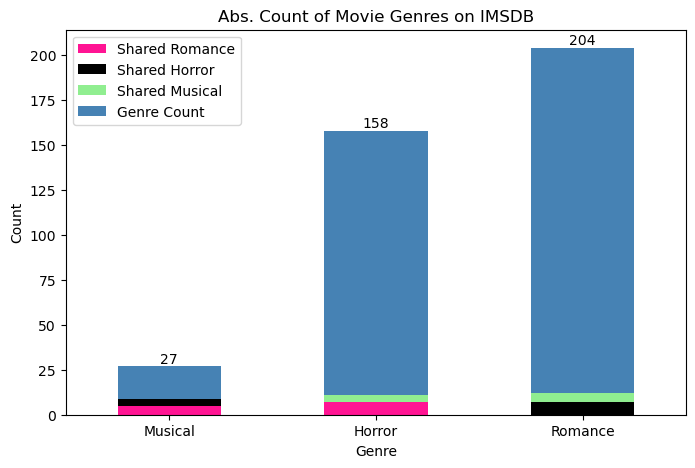

In [4]:
# Problem b

# Creating lists of movies that are classified as only one of musical, horror, or romance, and those that share genres
musical_only = []
horror_only = []
romance_only = []
musical_horror = []
musical_romance = []
horror_romance = []

# Adding movies to each of these lists
for i in range(0, len(script_list)):

    # Creating criteria for inclusion into each list
    crit1 = 'Musical' in script_list[i]['genres'] and 'Horror' not in script_list[i]['genres'] and 'Romance' not in script_list[i]['genres']
    crit2 = 'Horror' in script_list[i]['genres'] and 'Musical' not in script_list[i]['genres'] and 'Romance' not in script_list[i]['genres']
    crit3 = 'Romance' in script_list[i]['genres'] and 'Musical' not in script_list[i]['genres'] and 'Horror' not in script_list[i]['genres']
    crit4 = 'Musical' in script_list[i]['genres'] and 'Horror' in script_list[i]['genres']
    crit5 = 'Musical' in script_list[i]['genres'] and 'Romance' in script_list[i]['genres']
    crit6 = 'Romance' in script_list[i]['genres'] and 'Horror' in script_list[i]['genres']

    # Appending movies to each genre list based on the criteria
    if crit1:
        musical_only.append(script_list[i])
    if crit2:
        horror_only.append(script_list[i])
    if crit3:
        romance_only.append(script_list[i])
    if crit4:
        musical_horror.append(script_list[i])
    if crit5:
        musical_romance.append(script_list[i])
    if crit6:
        horror_romance.append(script_list[i])

# Creating vectors for the genres, count of movies within each genre, number of movies that are coded as other genres, and proportions
genre = ['Musical', 'Horror', 'Romance']
genre_count = [len(musical_only), len(horror_only), len(romance_only)]
shared_musical = [0, len(musical_horror), len(musical_romance)]
shared_horror = [len(musical_horror), 0, len(horror_romance)]
shared_romance = [len(musical_romance), len(horror_romance), 0]

# Creating a pandas dataframe of these values
df = pd.DataFrame({
    'Genre': genre,
    'Genre Count': genre_count,
    'Shared Musical': shared_musical,
    'Shared Horror': shared_horror,
    'Shared Romance': shared_romance
})

# Initializing the plot
plot1 = df.plot(x='Genre', y=['Shared Romance', 'Shared Horror', 'Shared Musical', 'Genre Count'],
                kind='bar', rot = 0, title = 'Abs. Count of Movie Genres on IMSDB',
                ylabel = "Count", figsize = (8, 5), stacked = True, color = ['deeppink', 'black', 'lightgreen', 'steelblue'])

# Adding labels over the bars for the raw count
for i, v in enumerate(df['Genre Count']):
    plot1.text(i, v + df['Shared Musical'][i] + df['Shared Horror'][i] + df['Shared Romance'][i] + 0.1,
               str(v + df['Shared Musical'][i] + df['Shared Horror'][i] + df['Shared Romance'][i]), ha='center', va='bottom')

__(c, i)__ Using only regex, write a function `tokenizer` that returns bigrams of all non-whitespace and non-punctuation characters, according to the test case below: 

```python
test = '''
    Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed quia non numquam eius modi tempora 
    incidunt ut labore et dolore magnam aliquam quaerat voluptatem.
'''
tokenizer(test)
>>> ['neque porro',
 'porro quisquam',
 'quisquam est',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'adipisci velit',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']
 ```

In [5]:
# Problem c, part (i)

# Defining a function that takes a text string as input and outputs a list of string bigram entries
def tokenizer(input_text):

    # Remove punctuation and convert to lowercase
    cleaned_text = re.sub(r'[^\w\s]', '', input_text).lower()

    # Remove extra white space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Create list of bigram tuples
    bigram_list = re.findall(r'(\b\w+\b) (?=(\b\w+\b))', cleaned_text)

    # Collapse list of bigram tuples into list of string entries
    bigrams = []
    for i in range(0, len(bigram_list)):
        bigram = bigram_list[i][0] + ' ' + bigram_list[i][1]
        bigrams.append(bigram)

    return bigrams

# Initializing the test case, with some additional punctuation added in to test
test = '''
    Neque porro quisqua'm est, qui dolorem   ipsum quia dolor sit amet, 
    consectetur, adipisci velit, sed   quia non numquam; eius modi tempora 
    inci;dunt ut labore: et  dolore magnam! aliquam quaerat voluptatem.
'''

test_tokenized = tokenizer(test)
test_tokenized

['neque porro',
 'porro quisquam',
 'quisquam est',
 'est qui',
 'qui dolorem',
 'dolorem ipsum',
 'ipsum quia',
 'quia dolor',
 'dolor sit',
 'sit amet',
 'amet consectetur',
 'consectetur adipisci',
 'adipisci velit',
 'velit sed',
 'sed quia',
 'quia non',
 'non numquam',
 'numquam eius',
 'eius modi',
 'modi tempora',
 'tempora incidunt',
 'incidunt ut',
 'ut labore',
 'labore et',
 'et dolore',
 'dolore magnam',
 'magnam aliquam',
 'aliquam quaerat',
 'quaerat voluptatem']

__(ii)__ Use the tokenizer to obtain a tf-idf vector for each movie. Perform a (non-centered) principal component analysis (`sklearn.decomposition.TruncatedSVD`). _What fraction of variation is explained by the first principal component?_ __(iii)__ Generate a strip-plot for the first principal components versus all three genres. Does visualization indicate that a good classification could result from this approach? 

In [6]:
# Problem c, part (ii)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Creating a list of scripts containing the script text for each script
scripts = []
for i in has_script:
    scripts.append(script_list[i]['script'])

# Creating tf-idf vector for each movie
vec = TfidfVectorizer(tokenizer = tokenizer) 
tfidf = vec.fit_transform(scripts)

# Creating the TruncatedSVD object for the first principal component
svd = TruncatedSVD(n_components = 1)

# Fit and transform the data
transformed_data = svd.fit_transform(tfidf)

# Getting the explained variance for the first principal component
explained_variance_ratio = svd.explained_variance_ratio_

# Computing the total variance explained by the first principal component
total_variance_explained = explained_variance_ratio.sum()
total_variance_explained

0.004692044740020741

SOLUTION: The first principle component explains roughly 0.5% of the variation across all of the movie scripts on IMSDB.

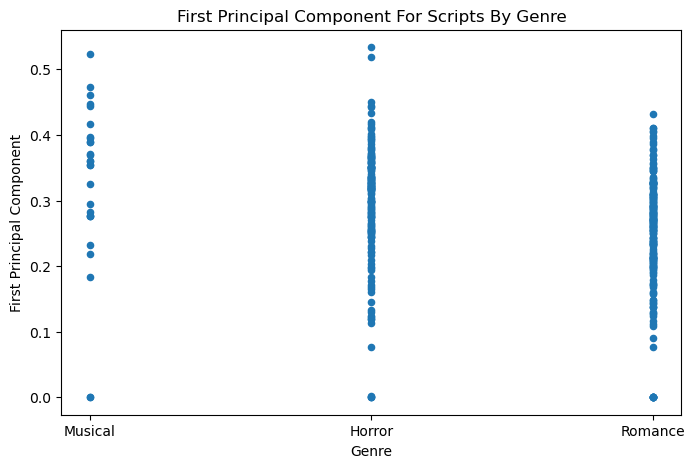

In [7]:
# Problem c, part (iii)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# Creating lists of all movies in each genre: Musical, Horror, and Romance
musical = musical_only + musical_horror + musical_romance
horror = horror_only + musical_horror + horror_romance
romance = romance_only + musical_romance + horror_romance

# Creating list of only the scripts for each genre: Musical, Horror, and Romance
musical_scripts = []
horror_scripts = []
romance_scripts = []
for m in musical:
    musical_scripts.append(m['script'])
for h in horror:
    horror_scripts.append(h['script'])
for r in romance:
    romance_scripts.append(r['script'])

# First PC for Musical scripts

# TF-IDF Vectorization and Truncated SVD for first PC
m_vec = TfidfVectorizer(tokenizer = tokenizer)
m_svd = TruncatedSVD(n_components = 1)

# Create a pipeline for convenience
m_pipeline = make_pipeline(m_vec, m_svd)

# Fit and transform the text data
m_pc = m_pipeline.fit_transform(musical_scripts)

# First PC for Horror scripts

# TF-IDF Vectorization and Truncated SVD for first PC
h_vec = TfidfVectorizer(tokenizer = tokenizer)
h_svd = TruncatedSVD(n_components = 1)

# Create a pipeline for convenience
h_pipeline = make_pipeline(h_vec, h_svd)

# Fit and transform the text data
h_pc = h_pipeline.fit_transform(horror_scripts)

# First PC for Romance scripts

# TF-IDF Vectorization and Truncated SVD for first PC
r_vec = TfidfVectorizer(tokenizer = tokenizer)
r_svd = TruncatedSVD(n_components = 1)

# Create a pipeline for convenience
r_pipeline = make_pipeline(r_vec, r_svd)

# Fit and transform the text data
r_pc = r_pipeline.fit_transform(romance_scripts)

# Creating a list of genres
genres = ['Musical' for _ in range(27)] + ['Horror' for _ in range(158)] + ['Romance' for _ in range(204)]

# Creating an array of PC values
pc_vals = np.concatenate((m_pc, h_pc, r_pc))
pc_vals = np.concatenate(pc_vals)

# Creating a pandas dataframe of genre and PC values
script_df = pd.DataFrame({
    'Genre': genres,
    'First PC': pc_vals
})

# Creating strip plot
plot2 = script_df.plot(x='Genre', y=['First PC'],
                kind='scatter', rot = 0, title = 'First Principal Component For Scripts By Genre',
                ylabel = "First Principal Component", figsize = (8, 5))

SOLUTION: The distributions of first principal component values for each script within each genre does appear to differ slightly between the Musical, Horror, and Romance genres. This indicates that this method could be a good way to classify movie scripts as different genres nased only on their script text.